Matthew Mason  
Project for Introduction to Data Analysis  
Data Analyst Nanodegree by Udacity

# Introduction

Udacity has provided us a dataset comprising a subset of the passengers aboard the Titanic when she sank.

The dataset includes the following columns.

```
PassengerId    A unique integer from 1 to 891 for each of the 891 passengers in this dataset  
Survived       1 if the passenger survived.  0 if the passenger died.  
Pclass         1, 2, or 3, depending on whether the passenger was in first, second, or third class  
Name           The passenger's name  
Sex            female or male  
Age            The passenger's age  
SibSp          The number of siblings plus any spouse aboard the Titanic  
Parch          The number of parents and children aboard the Titanic  
Ticket         The passenger's ticket number  
Fare           The passenger's fare  
Cabin          The passenger's cabin number  
Embarked       The port from which the passenger embarked
```

# Research Question
Which categorical features are associated with survival?

# Data Wrangling and Feature Engineering
We begin with some preliminary matters:  importing packages, defining global variables, and importing the dataset as a pandas DataFrame.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
%matplotlib inline

# Some global variables for code legibility  
# Color scheme from https://seaborn.pydata.org/tutorial/color_palettes.html#palette-tutorial
denim_blue = '#3b5b92'     # https://xkcd.com/color/rgb/
pale_red = '#d9544d'       # https://xkcd.com/color/rgb/
medium_green = '#39ad48'   # https://xkcd.com/color/rgb/
ultramarine = '#2000b1'    # https://xkcd.com/color/rgb/
light_sky_blue = '#c6fcff' # https://xkcd.com/color/rgb/
cement = '#a5a391'         # https://xkcd.com/color/rgb/
venus = '$\u2640$'
mars = '$\u2642$'

df = pd.read_csv('titanic-data.csv') # Titanic dataset from Data Analyst Nanodegree web site

We will now check for missing and irregular values.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


From the above, we see we are missing values from Age, Cabin, and Embarked.  For the missing Age values, we will add a new column AgeNoNaNs that is identical to Age but deals with the NaNs that are present in the Age column.

The only location where we will use the AgeNoNaNs column is in the very last chart, where we provide a scatter plot in multiple dimensions.  Imputing or inferring values for the missing age values would be misleading.  Given there are multiple dimensions, we can chart datapoints in dimensions other than age without replacing the missing age values with contrived values.

We will replace the NaNs in the AgeNoNaNs column with -20.  This will separate the datapoints with the NaNs in the last chart, plotting them at the far left-hand side of the Age axis.

In [3]:
# Converting NaN values in 'Age' to -20 for later use.

df['AgeNoNaNs'] = df['Age'].fillna(-20) # Note the default for DataFrame.fillna() is inplace=False

We can extract Deck from Cabin by adapting code from https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/

In [4]:
# Extract Deck from Cabin column and print number of passengers on each deck (of those passengers who had deck information).

'''
Begin adapted code
'''
def substrings_in_string(big_string, substrings):
    big_string=str(big_string)
    for substring in substrings:        
        if big_string.find(substring) != -1:
            return substring
    return np.nan

cabin_list = ['A','B','C','D','E','F','T','G','Unknown']
df['Deck'] = df['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
'''
End adapted code
'''
print ("Cabin total:  ",df['Cabin'].value_counts().sum()) # Many values missing in Cabin column
print ("Deck total:   ",df['Deck'].value_counts().sum())  # As expected, same number of values missing in Deck column
print ("Fraction of records with Deck information:  ",df['Deck'].value_counts().sum() / len(df))
print ('')
print ("Count per Deck follows.")
decks_df = pd.DataFrame(df['Deck'].value_counts())
decks_df.index.name = 'Deck'
decks_df.rename(columns={'Deck':'Count'})

Cabin total:   204
Deck total:    204
Fraction of records with Deck information:   0.22895622895622897

Count per Deck follows.


,Count
Deck,
C,59
B,47
E,33
D,33
A,15
F,12
G,4
T,1


We can make linear combinations of columns to generate more features.  For example, we can add SibSp and Parch to make a new column called "FamSize".  (The family size column was a suggestion in https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)

In [5]:
# Creating Family Size feature.

df['FamSize'] = df['SibSp'] + df['Parch']
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeNoNaNs,Deck,FamSize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,NaN,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,C,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,NaN,0


We will now create bar charts for categorical features and histograms for continuous features.  We start with the number of survivors and then consider survival by sex.

,Count,Percent
Survived,,
0,549,61.616162
1,342,38.383838


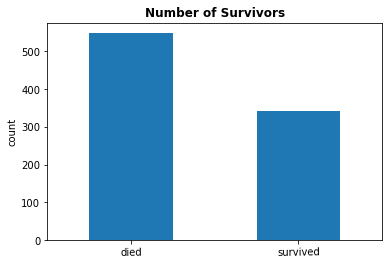

In [6]:
# Defining functions for bar chart and corresponding table.

def categorical_plot (Dataframe, xaxis_column, yaxis_column, title, y_label, xtick_labels):
    ax = Dataframe.groupby(xaxis_column).count().plot.bar(y=yaxis_column)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel(y_label)
    ax.set_xticklabels(xtick_labels, rotation=1)
    ax.legend_.remove()
    return ax

def display_count_and_percentage (old_dataframe, new_dataframe, column_for_index, column_for_count):
    new_dataframe = old_dataframe.groupby(column_for_index)[[column_for_count]].count()
    new_dataframe['Percent'] = ( new_dataframe[column_for_count] / len(old_dataframe) ) * 100
    new_dataframe.columns = ['Count', 'Percent']
    return new_dataframe
    
# Plotting number of survivors.

categorical_plot(df, ['Survived'], ['PassengerId'], 'Number of Survivors', 'count', ['died', 'survived'])
survival_df = display_count_and_percentage(df, 'survival_df', ['Survived'], ['PassengerId'])
survival_df

,Count,Percent
Sex,,
female,314,35.241302
male,577,64.758698


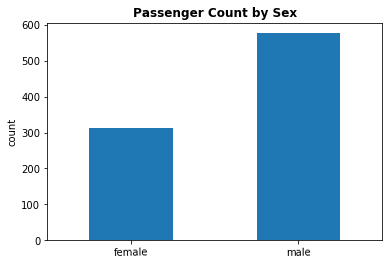

In [7]:
# Plotting passenger count by sex.

categorical_plot(df, ['Sex'], ['PassengerId'],'Passenger Count by Sex', 'count', ['female', 'male'])
Sex_df = (display_count_and_percentage(df, 'Sex_df', ['Sex'], ['PassengerId']))
Sex_df

Count    Percent
Sex    Survived                  
female 0            81   9.090909
       1           233  26.150393
male   0           468  52.525253
       1           109  12.233446

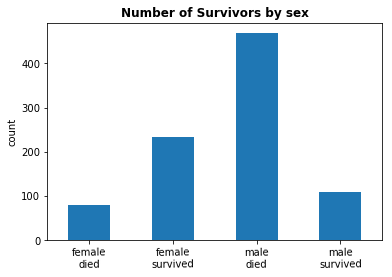

In [8]:
# Plotting survivors by sex.

categorical_plot(df, ['Sex', 'Survived'], ['PassengerId'], 'Number of Survivors by sex', 'count', ['female\ndied', 'female\nsurvived', 'male\ndied', 'male\nsurvived'])
Sex_surv_df = display_count_and_percentage(df, 'Sex_surv_df', ['Sex', 'Survived'], ['PassengerId'])
Sex_surv_df

In the next few cells, we will check the distribution of the following variables:  Age, Pclass, SibSp, Parch, FamSize, and Fare.  We will want to know if the distributions do not support any particular statistical test.  For example, in the Exploration section, we perform chi-squared tests of categorical variables.  Generally, a chi-squared test may be unreliable if an observed frequency is less than 5.  

We will also view the relation of each of the variables to survival.

In [9]:
# Reporting Age statistics.

print ('Number of passengers under age 18:    {:d}'.format((df[df['Age']<18]).count()['PassengerId']))
print ('Number of passengers age 65 or older:  {:d}'.format(df[df['Age']>=65].count()['PassengerId']))
pd.DataFrame(df['Age'].describe())

Number of passengers under age 18:    113
Number of passengers age 65 or older:  11


,Age
count,714.000000
mean,29.699118
std,14.526497
min,0.420000
25%,20.125000
50%,28.000000
75%,38.000000
max,80.000000


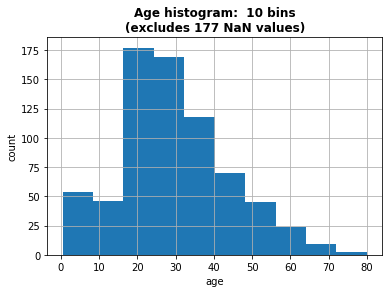

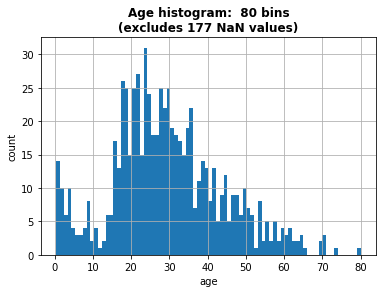

In [10]:
# Plotting histograms of ages.

ax = df['Age'].hist()
ax.set_title('Age histogram:  10 bins\n(excludes {:d} NaN values)'.format(df['Age'].isnull().sum()), fontweight='bold')
ax.set_xlabel('age')
ax.set_ylabel('count')
plt.show()
ax = df['Age'].hist(bins=80)
ax.set_title('Age histogram:  80 bins\n(excludes {:d} NaN values)'.format(df['Age'].isnull().sum()), fontweight='bold')
ax.set_xlabel('age')
ax.set_ylabel('count')
plt.show()

,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
died,424.0,30.626179,14.172110,1.00,21.0,28.0,39.0,74.0
survived,290.0,28.343690,14.950952,0.42,19.0,28.0,36.0,80.0


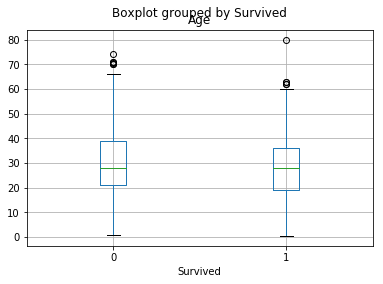

In [11]:
# Boxplot of Age and Survival

df.boxplot(column=['Age'], by='Survived')
age_df = pd.DataFrame(df.groupby(['Survived'])['Age'].describe()).rename(index={0:'died',1:'survived'})
age_df.index.names = ['']
age_df

,Count,Percent
Pclass,,
1,216,24.242424
2,184,20.650954
3,491,55.106622


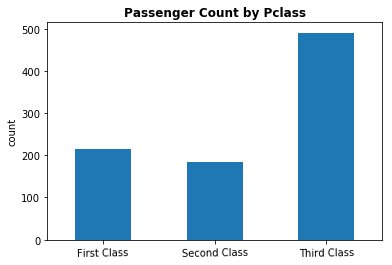

In [12]:
# Plotting passenger count by Pclass.

categorical_plot(df, ['Pclass'], ['PassengerId'],'Passenger Count by Pclass', 'count', ['First Class', 'Second Class', 'Third Class'])
Pclass_df = (display_count_and_percentage(df, 'Pclass_df', ['Pclass'], ['PassengerId']))
Pclass_df

Count    Percent
Pclass Survived                  
1      0            80   8.978676
       1           136  15.263749
2      0            97  10.886644
       1            87   9.764310
3      0           372  41.750842
       1           119  13.355780

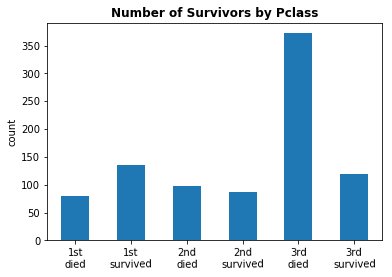

In [13]:
# Plotting number of survivors by Pclass.

categorical_plot(df, ['Pclass','Survived'], ['PassengerId'],'Number of Survivors by Pclass', 'count', ['1st\ndied', '1st\nsurvived', '2nd\ndied', '2nd\nsurvived', '3rd\ndied', '3rd\nsurvived'])
Pclass_Surv_df = display_count_and_percentage(df, 'Pclass_Surv_df', ['Pclass','Survived'], ['PassengerId'])
Pclass_Surv_df

Count    Percent
SibSp Survived                  
0     0           398  44.668911
      1           210  23.569024
1     0            97  10.886644
      1           112  12.570146
2     0            15   1.683502
      1            13   1.459035
3     0            12   1.346801
      1             4   0.448934
4     0            15   1.683502
      1             3   0.336700
5     0             5   0.561167
8     0             7   0.785634

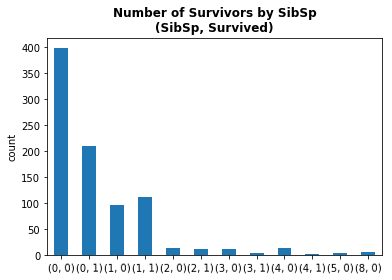

In [14]:
# Plotting survivors by SibSp.

SibSp_df = df.groupby(['SibSp', 'Survived']).mean()
ax = categorical_plot(df, ['SibSp', 'Survived'], ['PassengerId'], 'Number of Survivors by SibSp\n(SibSp, Survived)', 'count', SibSp_df.index.values)
SibSp_df = display_count_and_percentage(df, SibSp_df, ['SibSp', 'Survived'], ['PassengerId'])
SibSp_df

Count    Percent
Parch Survived                  
0     0           445  49.943883
      1           233  26.150393
1     0            53   5.948373
      1            65   7.295174
2     0            40   4.489338
      1            40   4.489338
3     0             2   0.224467
      1             3   0.336700
4     0             4   0.448934
5     0             4   0.448934
      1             1   0.112233
6     0             1   0.112233

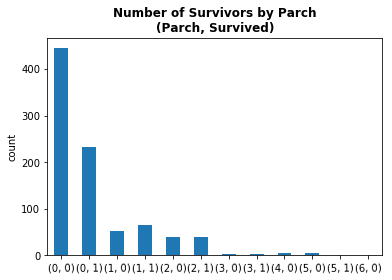

In [15]:
# Plotting survivors by Parch.

Parch_df = df.groupby(['Parch', 'Survived']).mean()
ax = categorical_plot(df, ['Parch', 'Survived'], ['PassengerId'], 'Number of Survivors by Parch\n(Parch, Survived)', 'count', Parch_df.index.values)
Parch_df = display_count_and_percentage(df, Parch_df, ['Parch', 'Survived'], ['PassengerId'])
Parch_df

Count    Percent
FamSize Survived                  
0       0           374  41.975309
        1           163  18.294052
1       0            72   8.080808
        1            89   9.988777
2       0            43   4.826038
        1            59   6.621773
3       0             8   0.897868
        1            21   2.356902
4       0            12   1.346801
        1             3   0.336700
5       0            19   2.132435
        1             3   0.336700
6       0             8   0.897868
        1             4   0.448934
7       0             6   0.673401
10      0             7   0.785634

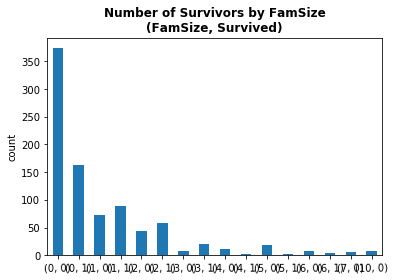

In [16]:
# Plotting survivors by FamSize.

FamSize_df_2 = df.groupby(['FamSize', 'Survived']).mean() # FamSize_df_2 is just for this section.  FamSize_df is used later.
ax = categorical_plot(df, ['FamSize', 'Survived'], ['PassengerId'], 'Number of Survivors by FamSize\n(FamSize, Survived)', 'count', FamSize_df_2.index.values)
FamSize_df_2 = display_count_and_percentage(df, FamSize_df_2, ['FamSize', 'Survived'], ['PassengerId'])
FamSize_df_2

Fare is a continuous variable, and survival is a categorical variable.  We will plot survival against fare using a boxplot.

,mean fare,std. dev. of fare
Survived,,
0,22.117887,31.388207
1,48.395408,66.596998


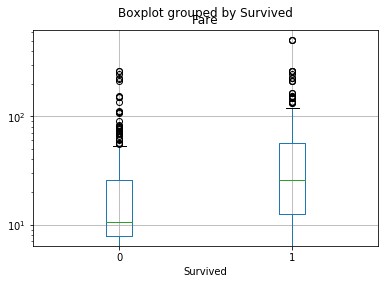

In [17]:
# Boxplot of Fare and Survival

df.boxplot(column=['Fare'], by='Survived').set_yscale('log')
fare_surv_df = df.groupby(['Survived'])['Fare'].describe().loc[:,['mean','std']]
fare_surv_df.columns = ['mean fare', 'std. dev. of fare']
fare_surv_df

Age and Fare are both continuous variables.  We will plot the count by age and fare using hexagonal binning.  The plot may not be especially informative to the question of which variables are associated with survival.  However, this is an academic exercise, and the plot below is an example of how we can visualize the relation between two continuous variables.  If we were to expand this study to include multiple regression, we might spend more time altering the Fare axis to produce a nonlinear scale that increases the relative space of lower values to expand the portion of Fare from 0 to 100.

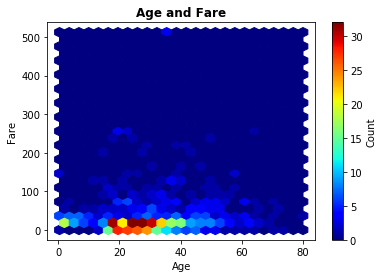

In [18]:
# A scatter plot of two continuous features:  Age and Fare.

fig, ax2 = plt.subplots()
ax = ax2.hexbin(x=df['Age'], y=df['Fare'], gridsize=25, cmap='jet')
ax2.set_xlabel('Age')
ax2.set_ylabel('Fare')
ax2.set_title('Age and Fare', fontweight='bold')
fig.colorbar(ax, label='Count')
plt.show()

In the following cells, we create Dataframes for use in charts in the Evaluation section.

In [19]:
# Creating Dataframe indexed by FamSize.

FamSize_df = df.groupby('FamSize').mean()
FamSize_df['ProbSurvival'] = df.groupby('FamSize').mean()['Survived']
FamSize_df['ProbSurvFemale'] = df.loc[df['Sex']=='female'].groupby('FamSize').mean()['Survived']
FamSize_df['ProbSurvMale'] = df.loc[df['Sex']=='male'].groupby('FamSize').mean()['Survived']
FamSize_df['N'] = df.groupby('FamSize').count()['Survived']
FamSize_df['NFemale'] = df.loc[df['Sex']=='female'].groupby('FamSize').count()['Survived']
FamSize_df['FamSizeValues'] = FamSize_df.index.values # Adding column for family sizes that match indexes.
FamSize_df.loc[:,'ProbSurvival':'NFemale']

,ProbSurvival,ProbSurvFemale,ProbSurvMale,N,NFemale
FamSize,,,,,
0,0.303538,0.785714,0.155718,537,126
1,0.552795,0.816092,0.243243,161,87
2,0.578431,0.775510,0.396226,102,49
3,0.724138,0.842105,0.500000,29,19
4,0.200000,0.250000,0.000000,15,12
5,0.136364,0.375000,0.000000,22,8
6,0.333333,0.375000,0.250000,12,8
7,0.000000,0.000000,0.000000,6,2
10,0.000000,0.000000,0.000000,7,3


From the table above, those traveling in a family of four (i.e. FamSize==3 plus self) had a high likelihood (p=0.72) of survival.  While the value of N for each FamSize is greater than five, if we break FamSize down by gender, some of the values are less than five.  In the Evaluation section below, we will perform a chi-squared test using FamSize.

In [20]:
# Creating Dataframe for survival based on Pclass and Sex.

Class_Sex = df.groupby(['Pclass','Sex'])[['Survived']].mean()
Class_Sex['Count'] = df.groupby(['Pclass','Sex']).count()['Survived']
Class_Sex['SurvCount'] = df.loc[(df['Survived']==1)].groupby(['Pclass','Sex']).count()['Survived']
Class_Sex['DeathCount'] = df.loc[(df['Survived']==0)].groupby(['Pclass','Sex']).count()['Survived']
Class_Sex

Survived  Count  SurvCount  DeathCount
Pclass Sex                                           
1      female  0.968085     94         91           3
       male    0.368852    122         45          77
2      female  0.921053     76         70           6
       male    0.157407    108         17          91
3      female  0.500000    144         72          72
       male    0.135447    347         47         300

In [21]:
# Creating four Dataframes:  (1) surviving females, (2) non-surviving females, (3) surviving males, and (4) non-surviving males.

survivors_fem = df.loc[(df['Survived']==1) & (df['Sex']=='female')]
lost_souls_fem = df.loc[(df['Survived']==0) & (df['Sex']=='female')]
survivors_male = df.loc[(df['Survived']==1) & (df['Sex']=='male')]
lost_souls_male = df.loc[(df['Survived']==0) & (df['Sex']=='male')]

# Exploration
Let's calculate what variables had a significant effect on survival.  We will start by using a one-way chi-squared test of the independence of the Sex and Survived variables.

In [22]:
# Calculating chi-squared statistic for the independence of Sex and Survived. 
# The values in our contingency table are not small enough to warrant Yates's correction for continuity.

observed = pd.crosstab(index=df['Sex'], columns=df['Survived'])
chi2, p, dof, expected = stats.chi2_contingency(observed, correction=False) # Not applying Yates's correction for continuity.
print ('observed:')
print (observed)
print ('')
print ('expected:')
print (expected)
print ('')
print ('chi2:  ',chi2)
print ('p:     ',p)
print ('dof:   ',dof)

observed:
Survived    0    1
Sex               
female     81  233
male      468  109

expected:
[[ 193.47474747  120.52525253]
 [ 355.52525253  221.47474747]]

chi2:   263.050574071
p:      3.71174777011e-59
dof:    1


Let's take a moment to explain the code in the prior cell.  In the first line, we determine a contingency table that comprises our observed values.  The second line determines the chi-squared statistic, the p-value, the degrees of freedom, and the table of expected values.

In the last argument in the second line, we set ```correction=False``` to declare we are not using Yates's correction for continuity.  See https://en.wikipedia.org/wiki/Yates%27s_correction_for_continuity  The documentation for the function call in the second line is available at https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.chi2_contingency.html

In the remaining lines we print the variables we determined in the first two lines.  

A guideline is that the chi-squared test should be used only if the smallest value in the observed and expected frequency tables is at least 5.  The smallest observed value in the observed and expected frequency tables is 81, so we are free to use the chi-squared test.

We can determine the expected value table and chi-squared statistic manually to verify our result.  An example walk-through of determining the chi-squared test statistic for categorical data involving more than one variable is available at http://www.stat.yale.edu/Courses/1997-98/101/chisq.htm

$H_0=$ Survival is independent of sex.  
$H_A=$ Survival is associated with sex.

The p-value is extremely small, and we reject the null hypothesis.

We will use this test several times, so let's define a function.

In [23]:
def p_value_2D(dframe, var1, var2):
    observed = pd.crosstab(index=dframe[var1], columns=dframe[var2])
    chi2, p, dof, expected = stats.chi2_contingency(observed, correction=False) # Not applying Yates's correction for continuity.
    return p

p_value_2D(df, 'Survived', 'Sex') # Show that we obtain the same p-value as in the previous cell.

3.711747770113424e-59

We can use the ```p_value_2D``` function to create a table of p-values from chi-squared tests involving each pair of categorical variables.  We will not perform a chi-squared test on Deck because two of the decks have values less than 5.

In [24]:
categorical_columns = ['Survived', 'Pclass', 'Sex', 'Embarked']
p_value_table = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
for first_column in categorical_columns:
    for second_column in categorical_columns:
        if first_column != second_column:
            p=p_value_2D(df, first_column, second_column) # Embarked and Survived produces the same p-value with and without the dropna() command applied to Embarked.
            p_value_table.set_value(first_column, second_column, p)
        if first_column == second_column:
            p_value_table.set_value(first_column, second_column, '')
print ('P-values from Pearson\'s chi-squared test:')
p_value_table

P-values from Pearson's chi-squared test:


,Survived,Pclass,Sex,Embarked
Survived,,4.54925e-23,3.71175e-59,1.76992e-06
Pclass,4.54925e-23,,0.000206389,8.43527e-26
Sex,3.71175e-59,0.000206389,,0.00125852
Embarked,1.76992e-06,8.43527e-26,0.00125852,


Note all of the above p-values are less than 0.01.  We can conclude that each of these categorical variables are associated with the other categorical variables.

We now calculate the correlations (Pearson's r) for pairs of continuous variables.

In [25]:
# Calculating correlation of select variables.

def correlation(x, y): # This function copied from Data Analyst Nanodegree, Module 3, Lesson 5, part 8.
    std_x = (x - x.mean()) / x.std(ddof=0) # Note here we are using 0 degrees of freedom, as if we have the entire population. 
    std_y = (y - y.mean()) / y.std(ddof=0) #
    return (std_x * std_y).mean()

continuous_columns = ['Age', 'SibSp', 'Parch', 'Fare', 'FamSize']
correlation_value_table = pd.DataFrame(index=continuous_columns, columns=continuous_columns)
for first_column in continuous_columns:
    for second_column in continuous_columns:
        if first_column != second_column:
            corr=correlation(df[first_column], df[second_column])
            correlation_value_table.set_value(first_column, second_column, corr)
        if first_column == second_column:
            correlation_value_table.set_value(first_column, second_column, '')
print ('Correlations (Pearson\'s r):')
correlation_value_table

Correlations (Pearson's r):


,Age,SibSp,Parch,Fare,FamSize
Age,,-0.259864,-0.200173,0.102288,-0.277611
SibSp,-0.259864,,0.414838,0.159651,0.890712
Parch,-0.200173,0.414838,,0.216225,0.783111
Fare,0.102288,0.159651,0.216225,,0.217138
FamSize,-0.277611,0.890712,0.783111,0.217138,


Age and Fare are continuous variables.  Generally, it would be fair to deem SibSp, Parch, and FamSize continuous variables as well.  However, we might consider SibSp, Parch, and FamSize categorical variables.  All three have a "small" number of integral values.

Let's calculate the p-values from the chi-squared tests of independence for Survived with each of SibSp, Parch, and FamSize.

In [26]:
# Determining p-value from chi-squared test of independent for Survived with each of SibSp, Parch, and FamSize.

print ('p-value for SibSp and Survived:    {}'.format(p_value_2D(df, 'Survived', 'SibSp')))
print ('p-value for Parch and Survived:    {}'.format(p_value_2D(df, 'Survived', 'Parch')))
print ('p-value for FamSize and Survived:  {}'.format(p_value_2D(df, 'Survived', 'FamSize')))

p-value for SibSp and Survived:    1.5585810465902116e-06
p-value for Parch and Survived:    9.703526421039997e-05
p-value for FamSize and Survived:  3.579668975443533e-14


We see the p-values for Survived with each of SibSp, Parch, and FamSize are extremely small.  Survival is associated with SibSp, Parch, and FamSize.  We plot survival and family size below.

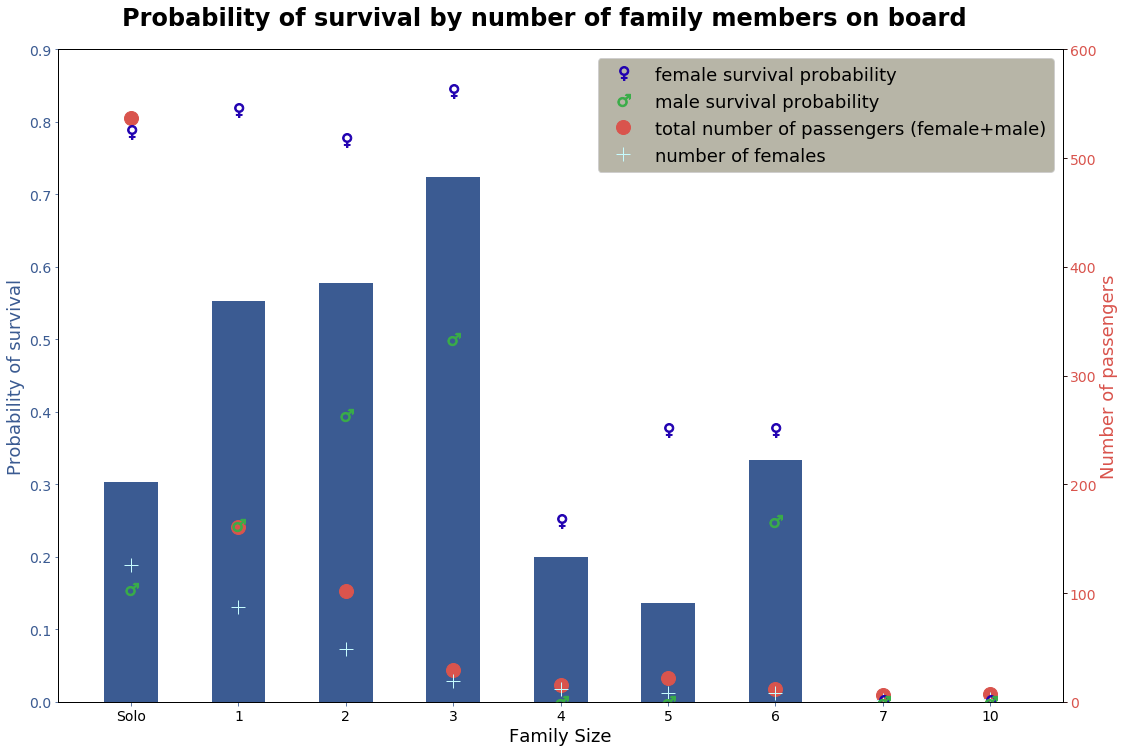

In [27]:
# Creating chart based on Dataframe indexed by FamSize.

fig = plt.figure(figsize=(18,12))
fig.suptitle('Probability of survival by number of family members on board', fontweight='bold', fontsize=24, y=.93)
markersize=14 # Isolate markersize variable to make easy manual adjustments.

ax = FamSize_df['ProbSurvival'].plot(kind='bar', color=denim_blue)
ax.set_ylim(0,.9,auto=False)
ax.set_xlabel('Family Size', fontsize=18)
ax.set_ylabel('Probability of survival', color=denim_blue, fontsize=18)
ax.tick_params(colors=denim_blue, labelsize=14)
plt.xticks(np.arange(9), ('Solo', '1', '2', '3', '4', '5', '6', '7', '10'),color='black', rotation=0, fontsize=14)

ax2 = ax.twinx()
ax2.set_ylim(0, 600, auto=False)
ax2.set_ylabel('Number of passengers',color=pale_red, fontsize=18)
ax2.tick_params(colors=pale_red, labelsize=14)
ax2.plot(ax.get_xticks(), FamSize_df['N'], c=pale_red, marker='o', markersize=markersize, linestyle='')

ax3 = ax.twinx()
ax3.set_ylim(0, 600, auto=False)
ax3.set_yticklabels([])
ax3.plot(ax.get_xticks(), FamSize_df['NFemale'], c=light_sky_blue, marker='+',markersize=markersize, linestyle='')

ax4 = ax.twinx()
ax4.set_ylim(0, .9, auto=False)
ax4.yaxis.set_tick_params(size=0)
ax4.set_yticklabels([])
ax4.plot(ax.get_xticks(), FamSize_df['ProbSurvFemale'], c=ultramarine, marker=venus, markersize=markersize, linestyle='')

ax5 = ax.twinx()
ax5.set_ylim(0, .9, auto=False)
ax5.yaxis.set_tick_params(size=0)
ax5.set_yticklabels([])
ax5.plot(ax.get_xticks(), FamSize_df['ProbSurvMale'], c=medium_green, marker=mars, markersize=markersize, linestyle='')

fem_surv_p = mlines.Line2D([], [], color=ultramarine, marker=venus, markersize=markersize, label='female survival probability', linestyle='')
male_surv_p = mlines.Line2D([], [], color=medium_green, marker=mars, markersize=markersize, label='male survival probability', linestyle='')
num_total = mlines.Line2D([], [], color=pale_red, marker='o', markersize=markersize, label='total number of passengers (female+male)', linestyle='')
num_females = mlines.Line2D([], [], color=light_sky_blue, marker='+', markersize=markersize, label='number of females', linestyle='')

legend = plt.legend(handles=[fem_surv_p, male_surv_p, num_total, num_females], fontsize=18)
legend.get_frame().set_facecolor(cement)
plt.show()

Note how male probability of survival increased from Solo to FamSize=3.

Now let's view the probability of survival by class and gender.

In [28]:
# Printing probability of survival based on Pclass and Sex
Class_Sex

Survived  Count  SurvCount  DeathCount
Pclass Sex                                           
1      female  0.968085     94         91           3
       male    0.368852    122         45          77
2      female  0.921053     76         70           6
       male    0.157407    108         17          91
3      female  0.500000    144         72          72
       male    0.135447    347         47         300

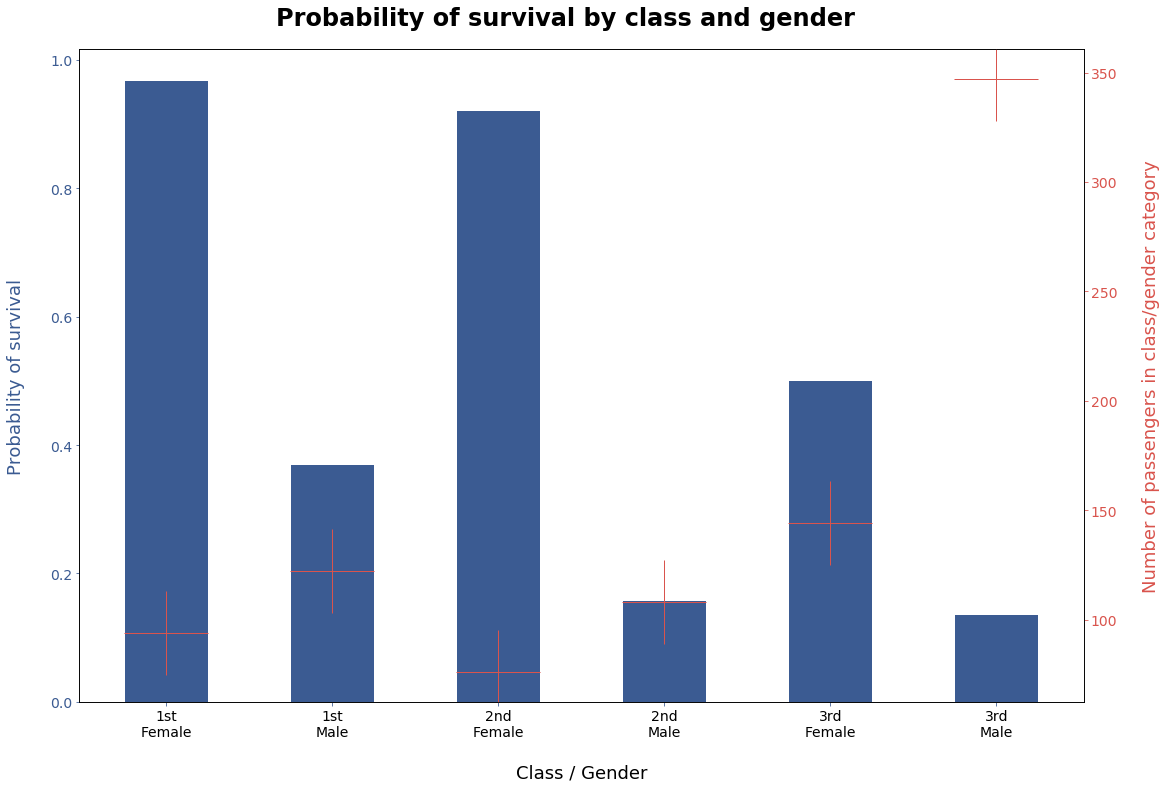

In [29]:
# Creating chart based on new Dataframe for survival based on Pclass and Sex.

fig = plt.figure(figsize=(18,12))
fig.suptitle('Probability of survival by class and gender', fontweight='bold', fontsize=24, y=.93)
size_marker = 84 # Isolate markersize variable to make easy manual adjustments.

ax = Class_Sex['Survived'].plot(kind="bar", color=denim_blue)
ax.set_xlabel('\nClass / Gender', fontsize=18)
ax.set_ylabel('Probability of survival\n', color=denim_blue, fontsize=18)
ax.tick_params(colors=denim_blue, labelsize=14)
plt.xticks(np.arange(6), ('1st\nFemale', '1st\nMale', '2nd\nFemale', '2nd\nMale', '3rd\nFemale', '3rd\nMale'), color='black', rotation=0, fontsize=14)

ax2 = ax.twinx()
ax2.set_ylabel('\nNumber of passengers in class/gender category', color=pale_red, fontsize=18)
ax2.tick_params(colors=pale_red, labelsize=14)
ax2.plot(ax.get_xticks(), Class_Sex['Count'], markersize=size_marker, c=pale_red, marker='+', linestyle='')

plt.show()

In the chart above, the "+" markers represent the number of passengers in each (class, gender) pair.

In the following scatter plot, we view the relationship between survival and class, age, family size and gender.

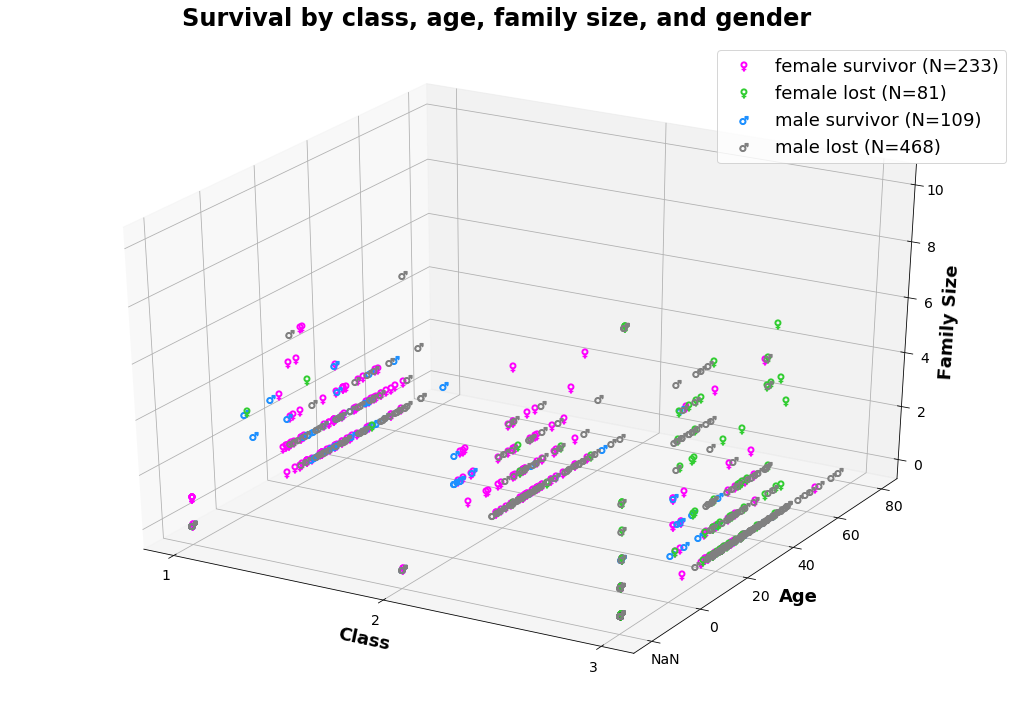

In [30]:
# Creating scatter plot of survival by class, age, family size, and gender.

fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle('Survival by class, age, family size, and gender',fontweight='bold', fontsize=24, y=.92)
markersize4d=85 # Isolate markersize variable to facilitate manual adjustments.

ax.scatter(survivors_fem['Pclass'], survivors_fem['AgeNoNaNs'], survivors_fem['FamSize'],c='magenta', marker=venus,s=markersize4d, label='female survivor (N={:d})'.format(survivors_fem.PassengerId.count()), depthshade=False)
ax.scatter(lost_souls_fem['Pclass'], lost_souls_fem['AgeNoNaNs'], lost_souls_fem['FamSize'],c='limegreen', marker=venus,s=markersize4d, label='female lost (N={:d})'.format(lost_souls_fem.PassengerId.count()), depthshade=False)
ax.scatter(survivors_male['Pclass'], survivors_male['AgeNoNaNs'], survivors_male['FamSize'],c='dodgerblue', marker=mars,s=markersize4d, label='male survivor (N={:d})'.format(survivors_male.PassengerId.count()), depthshade=False)
ax.scatter(lost_souls_male['Pclass'], lost_souls_male['AgeNoNaNs'], lost_souls_male['FamSize'],c='gray', marker=mars,s=markersize4d, label='male lost (N={:d})'.format(lost_souls_male.PassengerId.count()), depthshade=False)

ax.set_xlabel('\nClass', fontsize=18, fontweight='bold')
ax.set_ylabel('\nAge', fontsize=18, fontweight='bold')
ax.set_zlabel('Family Size', fontsize=18, fontweight='bold')

ax.xaxis.set_ticks((1,2,3))
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_ticks((-20, 0, 20, 40, 60, 80))
ax.yaxis.set_tick_params(labelsize=14)
ax.set_yticklabels(('NaN', 0, 20, 40, 60, 80))
ax.zaxis.set_tick_params(labelsize=14)

plt.legend(fontsize=18)
plt.show()

# Conclusions
The following categorical features are associated with survival:  Pclass, Sex, and Embarked.  If we deem SibSp, Parch, and FamSize categorical variables, then they too are associated with survival.

We viewed the age distribution of the passengers and the relationships between age and survival and age and fare.  We also viewed multi-dimensional features.  Specifically, we graphed sex and class against probability of survival, and we prepared a scatter plot of survival against class, age, and family size.

This dataset consists of 891 passengers, including 216 (24%) in First Class, 184 (21%) in Second Class, and 491 (55%) in Third Class.  Of these, 577 (65%) were male and 314 (35%) were female.  113 (13%) of these passengers were under the age of 18.

The actual number of people aboard was higher.  Various reports of the passenger and crew counts differ slightly.  An illustrative report is as follows.  There were approximately 1,317 passengers aboard when the Titanic sank.   324 (25%) were in First Class, 284 (22%) were in Second Class, and 709 (54%) were in Third Class. Of these, 869 (66%) were male and 447 (34%) female.  107 (8%) of these passengers were children.  (See https://en.wikipedia.org/wiki/RMS_Titanic#Passengers)

Additionally, there were 892 crew members aboard.  (See https://en.wikipedia.org/wiki/Sinking_of_the_RMS_Titanic).  Of these, only 214 crew members survived.  (See https://en.wikipedia.org/wiki/RMS_Titanic#Aftermath_of_sinking)

We do not know how this subset of passengers was selected from the larger passenger and crew manifest.  It is possible that there was some bias in selection.

Sources:  In addition to sources mentioned above, documentation from pandas, matplotlib, and scipy was consulted.  Stack Overflow was used as a starting point for several issues before delving further into documentation from the relevant packages.